### Libraries

In [ ]:
import gc
import warnings

warnings.filterwarnings('ignore')
from importlib import reload
%load_ext autoreload

In [ ]:
import dask
#import xrft
import ephem
import cmocean
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [ ]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [ ]:
#%reload_ext autoreload
%autoreload

#reload() solo funciona si el módulo ya fue cargado
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.filtering
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import kxky, f_range
import spectral_analysis.tools.utils_thesis
reload(spectral_analysis.tools.utils_thesis)
from spectral_analysis.common_vars.directories import DATA_FOLDER
#from spectral_analysis.tools.utils_thesis import igw_disp_rel, igw_bm_partition_k

from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import DATA_FOLDER
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
from spectral_analysis.common_vars.regions import lats4id, tzinfo_regions

print(DATA_FOLDER)

/mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data


### Define functions

In [ ]:
def kxky_(dx,dy,shape):
    Ny,Nx = shape
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*da.arange(-N_kx,N_kx+1)
    Ky = delta_ky*da.arange(-N_ky,N_ky+1)
    return Kx,Ky


def f_range_(dt,Nt):
    T = Nt*dt
    logging.info("f_range -- Nt: {}, T: {}".format(Nt,T))
    delta_om = 1/T
    N_om = (Nt-1)/2
    return  delta_om*da.arange(-N_om,N_om+1)

In [ ]:
## Units:
## kh,H: km
## f,Nbv: cph

def igw_disp_rel(kh, max_mode=10, f_coriolis=None, Nbv=0.8594, H=4.0, log=True):
    if log:
        print("N={0:.3f}, H={1:.3f} - mode {2}".format(Nbv, H, max_mode))
    kh = (2*np.pi)*kh 	# Transform to rad/km
    khnp_2 = (max_mode*np.pi/(kh*H))**2

    return da.sqrt( (Nbv**2 + ((f_coriolis**2)*khnp_2))/(1+khnp_2) )


def igw10_bm_partition_k(kh, fmax=1/12.0, **disp_kwargs):
    igw10 = igw_disp_rel(kh, max_mode=10, **disp_kwargs)
    logging.debug("igw10 shape: {}".format(igw10.shape))

    return da.fmin(igw10, fmax)


def create_igw10_cutoff(shape, dx=2.0, dy=2.0, dt=1.0, **partition_args):
    Nx,Ny,Nt = shape
    om_ = f_range_(dt,Nt)
    kx_,ky_ = kxky_(dx, dy, (Nx,Ny))
    kx,ky,om = da.meshgrid(kx_, ky_, om_)
    #logging.debug("spectral shape: {}, {}, {} --> {}, {}, {}", kx_.shape, ky_.shape, om_.shape, kx.shape, ky.shape, om.shape)

    kh_sq = da.square(kx)+da.square(ky)
    kh = da.sqrt(kh_sq)

    return igw10_bm_partition_k(kh, **partition_args), kx, ky, om


def create_filter_igw10(shape, order=50, **partition_args):
    cutoff_igw10, kx, ky, om = create_igw10_cutoff(shape,  **partition_args)
    logging.debug("cutoff_igw10 shape: {}".format(cutoff_igw10.shape))
    with np.errstate(over='ignore'):
        filter_mask_plt = 1/( 1 + ( da.square(om)/(cutoff_igw10**2) )**order )
        filter_mask = da.fft.ifftshift(filter_mask_plt)
        return filter_mask, kx, ky, om


In [ ]:
# TODO: multiplicar por Hanning

def fft_3d(var_txy, inverse=False):
    _v_fft = var_txy
    dim = len(var_txy.shape)
    for ax in range(dim):
        rechunks = {x:'auto' for x in range(dim) }
        rechunks[ax] = -1
        _v_fft = _v_fft.rechunk(rechunks)
        _v_fft = da.fft.fft(_v_fft, axis=ax) if not inverse else da.fft.ifft(_v_fft, axis=ax)
    return _v_fft

#@dask.delayed(pure=True)
def filter_fft_butterworth_k_omega(var_txy, filter_mask, dx=2.0, dy=2.0, dt_h=1, t_axis=-1):
    logging.info("kx-ky-omega BW filter -- variable shape: {} -- type: {}".format(var_txy.shape, type(var_txy)))
    arr_delayed_kwargs = {"shape": var_txy.shape, "dtype": np.dtype('f')}
    
    logging.info("Calculating FFT... mask type: {}".format(type(filter_mask)))
    #var_fft = xrft.fft(var_txy)
    var_fft = fft_3d(var_txy)
    logging.info("Filtering...")
    var_lo = filter_mask*var_fft
    del filter_mask
    
    # Volvemos al espacio físico
    logging.info("Calculating inverse FFT and complement")
    #var_lo = xrft.ifft(var_lo)
    var_lo = fft_3d(var_lo, inverse=True)
    logging.info("Taking real part FFT: {}".format(type(var_lo)))
    var_lo = da.real(var_lo)   # Eliminamos la parte imaginaria, ya que es espuria
    
    return var_lo


In [ ]:
import zoneinfo

## Calculates "real" date from simualtion hours, given a start date
startDt = datetime.datetime(2011,9,13,0,0,0,0,tzinfo=datetime.timezone.utc)

def simulationTime(hours):
    return startDt + datetime.timedelta(hours=hours)

def timeUtc(simHours):
    return ephem.Date(simulationTime(simHours))

## Init Dask cluster

In [ ]:
client = Client("tcp://127.0.0.1:9999")
client

2022-03-03 16:21:09 DEBUG    Using selector: EpollSelector
2022-03-03 16:21:09 DEBUG    Using selector: EpollSelector


<Client: 'tcp://127.0.0.1:9999' processes=4 threads=160, memory=60.00 GiB>

## Process region+season

In [ ]:
print(DATA_FOLDER)

/mnt/Datos4TB/antonio/Tesis/LLC4230/GDriveBackup/Tesis/data


In [135]:
regions_toprocess = {
    "Canarias": 730,#750
    "California": 787,#762
    "Benguela": 533,
    "Peru": 572
}

In [141]:
current = "Canarias"
rid = regions_toprocess[current]
season="JFM"
season_tag="Winter"

lat_deg = lats4id[rid]
tzone = tzinfo_regions[current] or "Universal" # By default

# Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
f_cph = id_data.f_cph
Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
H = id_data.H/1000

# For RV/DIV normalization
f_cps = f_cph/3600.0
f_rps = 2*np.pi*f_cps
f_rps_inv = 1.0/f_rps
print(rid, tzone, season, lat_deg, f_cph, f_cps, f_rps, f_rps_inv, Nbv_cph, H)

timevec = idx_t["hours"][season]
ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))

region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
grid = region.getGrid()
XG,YG = region.getGridG()

730 Atlantic/Azores JFM 21.611 0.0306925879065236 8.525718862923222e-06 5.356867149266304e-05 18667.627404890256 1.0138111316459193 4.4991768707482995


2022-03-07 20:14:14 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-03-07 20:14:14 INFO     Exists? 730: _Winter -- Filename /mnt/Datos4TB/antonio/Tesis/LLC4230/Postprocess/wk_spectra/730_Winter_hours.npz
2022-03-07 20:14:14 INFO     Spectra - Variables: []


#### Create base (0) checkpoint

In [142]:
region.get_uv()
UU, VV = region.get("uv")

UU

UU = UU.compute()
VV = VV.compute()

2022-03-07 20:14:22 INFO     Loading U: shape (k=0): (290, 289, 2184)
2022-03-07 20:14:22 INFO     Loading V: shape (k=0): (290, 289, 2184)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


In [143]:
ds = xr.Dataset(
    {
        "U": (["i", "j", "t"], UU),
        "V": (["i", "j", "t"], VV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}0.nc".format(DATA_FOLDER, rid, season))

del UU,VV
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18 24.18
    time     (t) object 1325376000000000000 ... 1333234800000000000
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 -0.1157 -0.08927 -0.07343 ... -0.03505 -0.02525
    V        (i, j, t) float32 0.05092 0.04221 -0.02638 ... -0.1395 -0.1361

#### Checkpoint 1

In [144]:
ds = xr.open_dataset("{}/datasets/{}_{}0.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>

In [145]:
RV = grid.rv(ds.U, ds.V)*f_rps_inv
DIV = grid.div(ds.U, ds.V)*f_rps_inv

RV

dask.array<mul, shape=(290, 289, 2184), dtype=float64, chunksize=(145, 209, 1092), chunktype=numpy.ndarray>

In [146]:
ds = xr.Dataset(
    {
        "RV": (["i", "j", "t"], RV),
        "DIV": (["i", "j", "t"], DIV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}1.nc".format(DATA_FOLDER, rid, season))

del RV,DIV
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:38399': 371,
 'tcp://127.0.0.1:41719': 380,
 'tcp://127.0.0.1:42495': 381,
 'tcp://127.0.0.1:43583': 447}

#### Load checkpoint 1

In [147]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    RV       (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    U        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>

#### Plot RV/DIV 

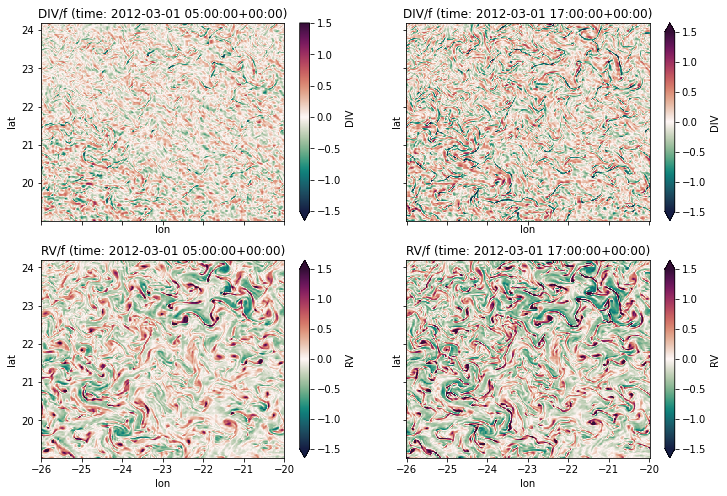

In [148]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = ds_time[t_idx]
_ds1.DIV.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (time: {})'.format(_t1))
_ds1.RV.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (time: {})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = ds_time[t_idx+12]
_ds2.DIV.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (time: {})'.format(_t2))
_ds2.RV.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (time: {})'.format(_t2))
fig_rvdiv_map = plt.gcf()

plt.show()

In [150]:
fig_rvdiv_map.savefig('figs/{}/RV-DIV_{}_am-pm_total.pdf'.format(rid, season))

2022-03-07 20:18:19 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-07 20:18:48 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-07 20:18:48 DEBUG    Writing TrueType font.


In [151]:
gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:38399': 543,
 'tcp://127.0.0.1:41719': 235,
 'tcp://127.0.0.1:42495': 998,
 'tcp://127.0.0.1:43583': 159}

#### Create filter

In [152]:
filter_mask, kx, ky, om = create_filter_igw10(ds.U.shape, fmax=1.0/12.75, f_coriolis=f_cph, Nbv=Nbv_cph, H=H)
filter_r = filter_mask.compute()

2022-03-07 20:19:21 INFO     f_range -- Nt: 2184, T: 2184.0
2022-03-07 20:19:21 INFO     kxky -- Nx: 289, Ny: 290
2022-03-07 20:19:21 INFO     kxky -- Lx: 578.0, Ly: 580.0
2022-03-07 20:19:21 DEBUG    igw10 shape: (290, 289, 2184)
2022-03-07 20:19:21 DEBUG    cutoff_igw10 shape: (290, 289, 2184)


N=1.014, H=4.499 - mode 10


#### Plot filter

In [153]:
## Only for plot purposes
filter_plot = np.fft.ifftshift(filter_r)
filter_mask_ = filter_plot[144,145:,1104:].squeeze().T

om_r = om.compute()
kx_r = kx.compute()
ky_r = ky.compute()
kx_ = kx_r[144,145:,1104:].squeeze().T
ky_ = ky_r[144,145:,1104:].squeeze().T
om_ = om_r[144,145:,1104:].squeeze().T

2022-03-07 20:21:00 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-07 20:21:00 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-07 20:21:00 DEBUG    Writing TrueType font.


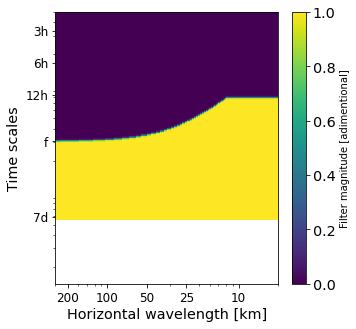

In [154]:
## Display a "cut" of the filter
plt.figure(figsize=(5,5))
plt.pcolormesh(kx_,om_,filter_mask_)
plt.xscale('log')
plt.xticks(ticks=[1/200., 1/100., 1/50., 1/25., 1/10.], labels=[200, 100, 50, 25, 10], size='large')
plt.xlim([1/250.,1/5.])
plt.yscale('log')
plt.yticks(ticks=[1/7./24.,f_cph, 1/12.0, 1/6., 1/3.], labels=['7d', 'f', '12h', '6h', '3h'], size='large')
plt.ylim([1/720.,1/2.])
plt.xlabel(r'Horizontal wavelength [km]',size='x-large')
plt.ylabel(r'Time scales',size='x-large')
cb = plt.colorbar()
cb.ax.tick_params(labelsize='x-large')
cb.set_label('Filter magnitude [adimentional]')
plt.savefig('figs/{}/wk_filter_2d.pdf'.format(rid))
plt.show()

In [155]:
1/om_r[0,0,1280]

11.586206896551724

2022-03-07 20:21:02 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-07 20:21:02 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-07 20:21:02 DEBUG    Writing TrueType font.


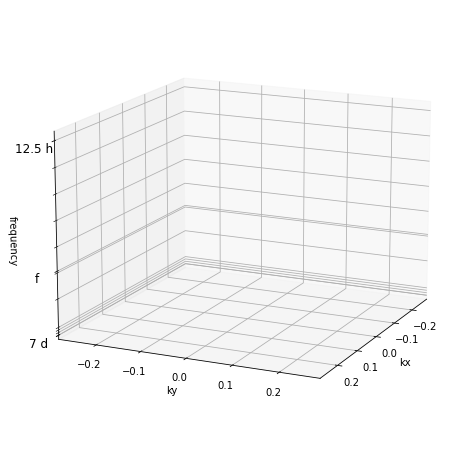

In [156]:
import matplotlib as mpl

om_idx = [i for i in range(om_r.shape[2])]
nlevels=10
#lvl = [i/nlevels for i in range(nlevels+1)]
lvl = [0.4,0.5]

min_ij=0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in om_idx[1150:1280:]:
    om_ = om_r[0,0,i]
    cs = ax.contourf(kx_r[min_ij:,min_ij:,i].squeeze(), ky_r[min_ij:,min_ij:,i].squeeze(), filter_r[min_ij:,min_ij:,i].squeeze(), zdir='z', offset=om_, levels=lvl, alpha=0.2)
ax.set_zscale('log')
ax.set_zlim(1/30., 1/12.2)
ax.set_zticks(ticks=[1/7./24.,f_cph, 1/12.5], labels=['7 d', 'f', '12.5 h'], size='large')
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('frequency')
ax.view_init(elev=15, azim=25)
plt.savefig('figs/{}/wk_filter_3d.pdf'.format(rid))

plt.show()

#### Filter data, save checkpoint 2

In [ ]:
U_lo = filter_fft_butterworth_k_omega(ds.U.data, filter_r)
V_lo = filter_fft_butterworth_k_omega(ds.V.data, filter_r)
U_hi = ds.U - U_lo
V_hi = ds.V - V_lo

2022-03-07 20:21:02 INFO     kx-ky-omega BW filter -- variable shape: (290, 289, 2184) -- type: <class 'dask.array.core.Array'>
2022-03-07 20:21:02 INFO     Calculating FFT... mask type: <class 'numpy.ndarray'>
2022-03-07 20:21:02 INFO     Filtering...


In [ ]:
ds = xr.Dataset(
    {
        "U_low": (["i", "j", "t"], U_lo),
        "V_low": (["i", "j", "t"], V_lo),
        "U_high":  U_hi, #(["i", "j", "t"], U_hi)
        "V_high": V_hi, #(["i", "j", "t"], V_hi)
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}2.nc".format(DATA_FOLDER, rid, season))
del U_lo, V_lo, U_hi, V_hi, filter_r, filter_mask
gc.collect()
client.run(gc.collect)

ds

#### Checkpoint 2

In [ ]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

In [ ]:
U_lo = ds.U_low #da.moveaxis(ds.U_low.data, -1, 0)
V_lo = ds.V_low #da.moveaxis(ds.V_low.data, -1, 0)
U_hi = ds.U_high #da.moveaxis(ds.U_high.data, -1, 0)
V_hi = ds.V_high #da.moveaxis(ds.V_high.data, -1, 0)

RV_lo = grid.rv(U_lo, V_lo)*f_rps_inv
DIV_lo = grid.div(U_lo, V_lo)*f_rps_inv
RV_hi = grid.rv(U_hi, V_hi)*f_rps_inv
DIV_hi = grid.div(U_hi, V_hi)*f_rps_inv

#### Calculate RV/DIV on filtered data, save checkpoint 3

In [ ]:
ds = xr.Dataset(
    {
        "RVlo": (["i", "j", "t"], RV_lo),
        "RVhi": (["i", "j", "t"], RV_hi),
        "DIVlo": (["i", "j", "t"], DIV_lo),
        "DIVhi": (["i", "j", "t"], DIV_hi),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}3.nc".format(DATA_FOLDER, rid, season))
del RV_lo, DIV_lo, RV_hi, DIV_hi, U_lo, V_lo, U_hi, V_hi
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 -80.0 -79.98 -79.96 -79.94 ... -74.04 -74.02 -74.0
    lat      (i, j) float64 -24.18 -24.18 -24.18 -24.18 ... -19.03 -19.03 -19.03
    time     (t) object 1325376000000000000 ... 1333234800000000000
Dimensions without coordinates: i, j, t
Data variables:
    RVlo     (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    RVhi     (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIVlo    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIVhi    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>

#### Load all checkpoints and plot filtered vs unfiltered, calculate RMS timeseries

In [ ]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DATA_FOLDER, rid, season), chunks='auto')

#_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
_tvec = pd.to_datetime(ds.time.values, unit='ns')
#ds["time"] = (["t"], _tvec)
#ds

#_tvec = ds.time.values

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(290, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    RV       (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    RVlo     (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    RVhi     (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIVlo    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    DIVhi    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    U        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(145, 209, 1092), meta=np.ndarray>
    U_low    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(145, 156, 728), meta=np.ndarray>

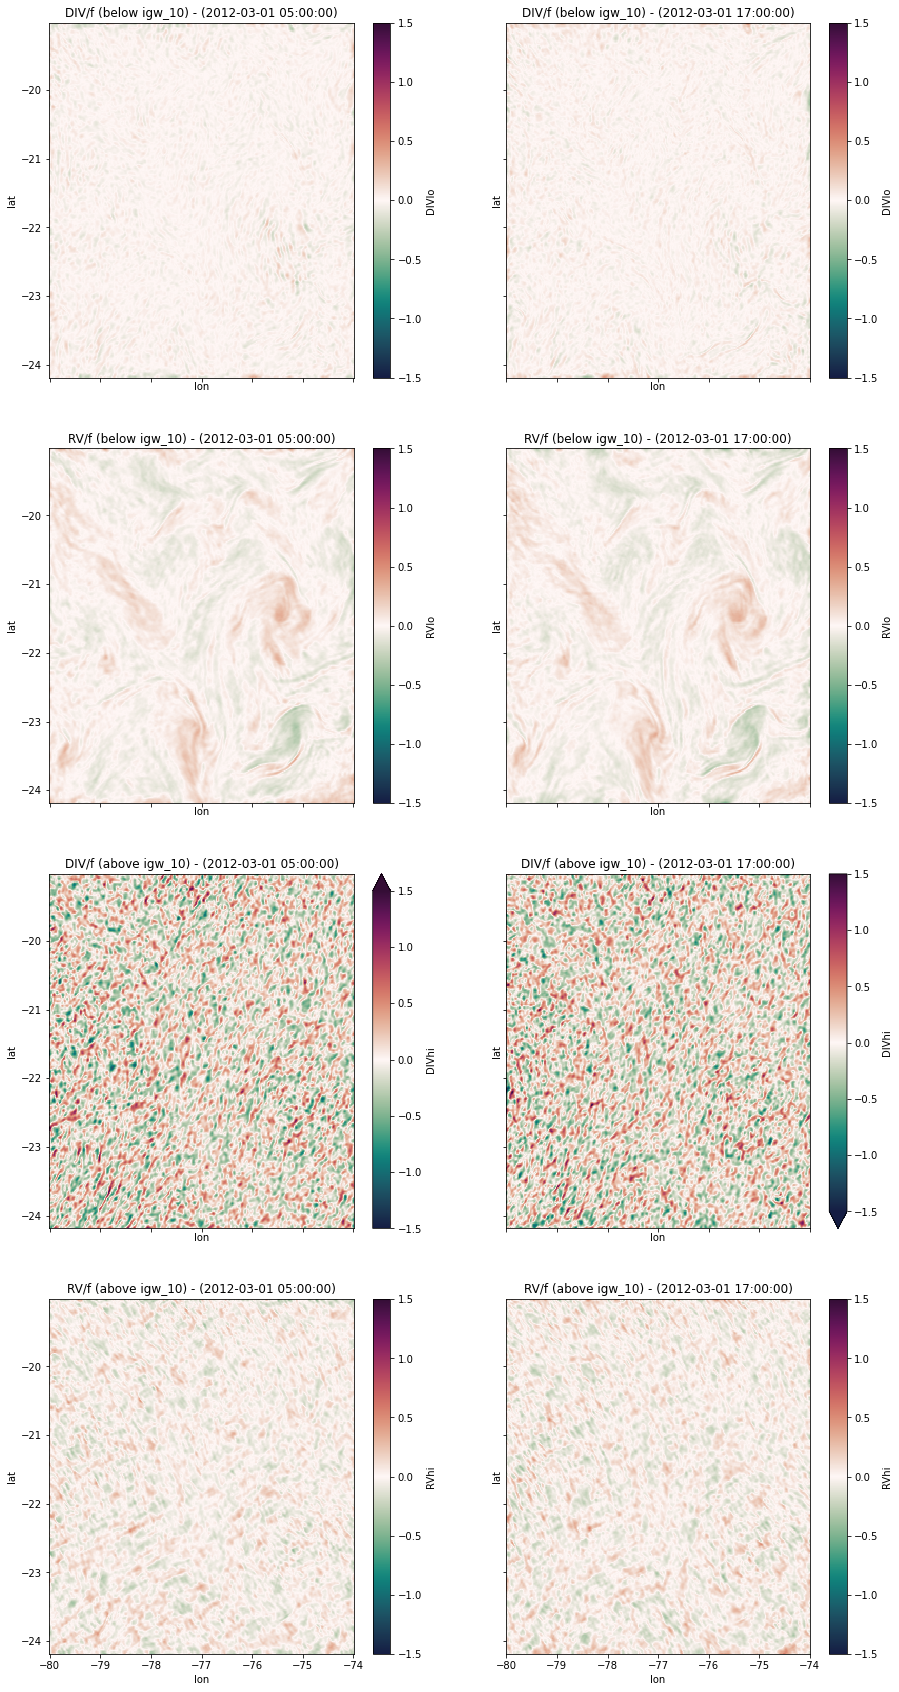

In [ ]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,30), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = _tvec[t_idx]
_ds1.DIVlo.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (below igw_10) - ({})'.format(_t1))
_ds1.RVlo.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (below igw_10) - ({})'.format(_t1))
_ds1.DIVhi.plot.pcolormesh(ax=ax[2,0], **fig_kwargs)
ax[2,0].set_title('DIV/f (above igw_10) - ({})'.format(_t1))
_ds1.RVhi.plot.pcolormesh(ax=ax[3,0], **fig_kwargs)
ax[3,0].set_title('RV/f (above igw_10) - ({})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = _tvec[t_idx+12]
_ds2.DIVlo.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (below igw_10) - ({})'.format(_t2))
_ds2.RVlo.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (below igw_10) - ({})'.format(_t2))
_ds2.DIVhi.plot.pcolormesh(ax=ax[2,1], **fig_kwargs)
ax[2,1].set_title('DIV/f (above igw_10) - ({})'.format(_t2))
_ds2.RVhi.plot.pcolormesh(ax=ax[3,1], **fig_kwargs)
ax[3,1].set_title('RV/f (above igw_10) - ({})'.format(_t2))

fig_rvdiv_filtered_map = plt.gcf()

plt.show()

In [ ]:
fig_rvdiv_filtered_map.savefig('figs/{}/RV-DIV_{}_am-pm.pdf'.format(rid, season))
#MALLOC_TRIM_THRESHOLD_

2022-03-03 16:37:10 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-03-03 16:38:13 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-03-03 16:38:13 DEBUG    Writing TrueType font.


#### Checkpoint 4: stats

In [ ]:
ds = xr.Dataset(
    {
        "RV_rms": ds.RV.std(dim=("i","j")),
        "DIV_rms": ds.DIV.std(dim=("i","j")),
        "RVlo_rms": ds.RVlo.std(dim=("i","j")),
        "DIVlo_rms": ds.DIVlo.std(dim=("i","j")),
        "RVhi_rms": ds.RVhi.std(dim=("i","j")),
        "DIVhi_rms": ds.DIVhi.std(dim=("i","j"))
    },
    coords={
        "time": (["t"], ds_time),
    }
)
ds.to_netcdf("{}/datasets/{}_{}4.nc".format(DATA_FOLDER, rid, season))

ds

<xarray.Dataset>
Dimensions:    (t: 2184)
Coordinates:
    time       (t) int64 1325376000000000000 ... 1333234800000000000
Dimensions without coordinates: t
Data variables:
    RV_rms     (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIV_rms    (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    RVhi_rms   (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIVhi_rms  (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>

### Load all checkpoints

In [121]:
ds = xr.open_mfdataset("{}/datasets/{}_{}*.nc".format(DATA_FOLDER, rid, season), chunks='auto')

#_tvec = list(map(lambda x: simulationTime(int(x)),ds.time.values))
_tvec = pd.to_datetime(ds.time.values, unit='ns')
ds["time"] = (["t"], _tvec)
#ds

#_tvec = ds.time.values

ds

<xarray.Dataset>
Dimensions:    (i: 288, j: 289, t: 2184)
Coordinates:
    lon        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time       (t) datetime64[ns] 2012-01-01 ... 2012-03-31T23:00:00
Dimensions without coordinates: i, j, t
Data variables: (12/18)
    RV         (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIV        (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    RV_rms     (t) float64 dask.array<chunksize=(2184,), meta=np.ndarray>
    DIV_rms    (t) float64 dask.array<chunksize=(2184,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(2184,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(2184,), meta=np.ndarray>
    ...         ...
    U          (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    V          (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    U_low      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_low      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_high     (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_high     (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>

### Plots: STDEV

In [122]:
ts_fig_kwargs={'x':'time', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-1.5, 'vmax':1.5}
trange_7days = slice(24*40,24*48)

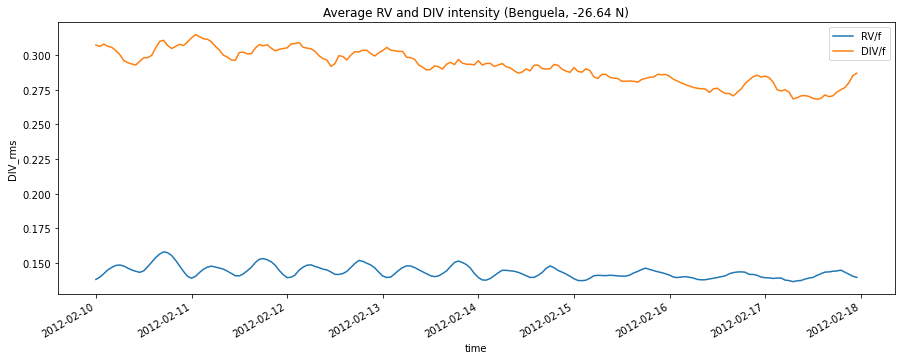

In [123]:
plt.figure(figsize=(15,5))
ds.RV_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIV_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current,lat_deg))
fig_stv7d_total = plt.gcf()
plt.show()

In [124]:
fig_stv7d_total.savefig('figs/{}/RV-DIV_{}_stdev_7days.png'.format(rid, season))

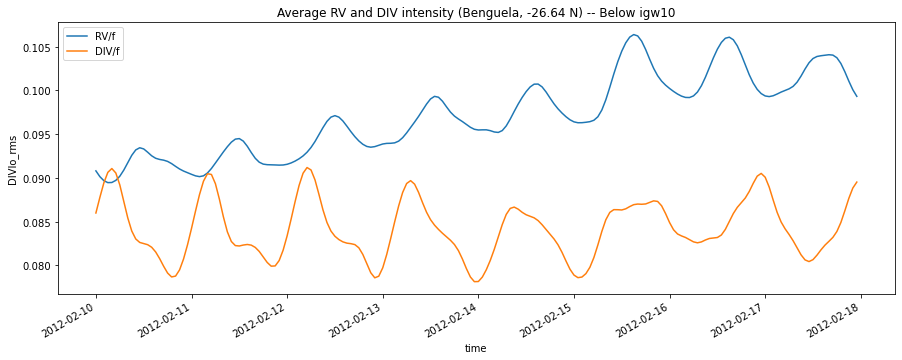

In [125]:
plt.figure(figsize=(15,5))
ds.RVlo_rms.isel(t=trange_7days).plot(label="RV/f", x="time")
ds.DIVlo_rms.isel(t=trange_7days).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current,lat_deg))
fig_stv7d_bm = plt.gcf()
plt.show()

In [126]:
fig_stv7d_bm.savefig('figs/{}/RV-DIV_{}_stdev_bm_7days.png'.format(rid, season))

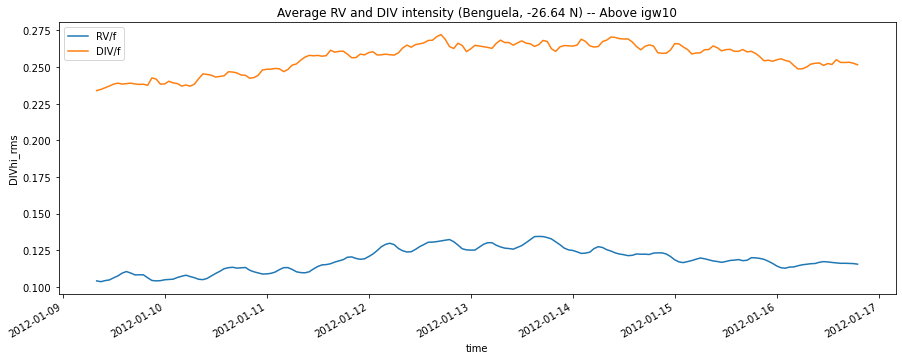

In [127]:
plt.figure(figsize=(15,5))
ds.RVhi_rms.isel(t=slice(200,380)).plot(label="RV/f", x="time")
ds.DIVhi_rms.isel(t=slice(200,380)).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current,lat_deg))
fig_stv7d_igw = plt.gcf()
plt.show()

In [128]:
fig_stv7d_igw.savefig('figs/{}/RV-DIV_{}_stdev_igw_7days.png'.format(rid, season))

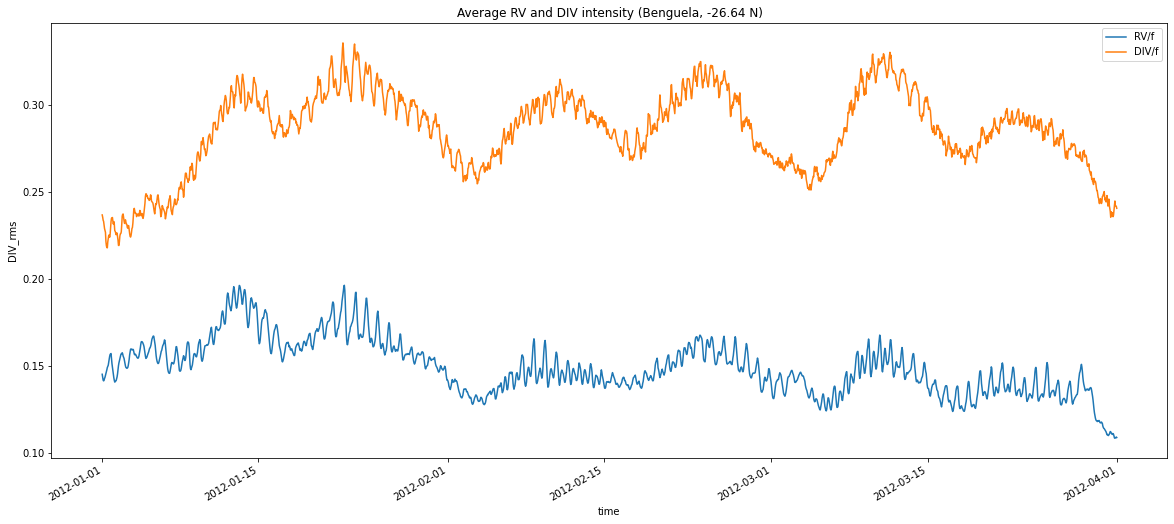

In [129]:
plt.figure(figsize=(20,8))
ds.RV_rms.plot(label="RV/f", x="time")
ds.DIV_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current, lat_deg))
fig_std_season = plt.gcf()
plt.show()

In [130]:
fig_std_season.savefig('figs/{}/RV-DIV_{}_stdev.png'.format(rid,season))

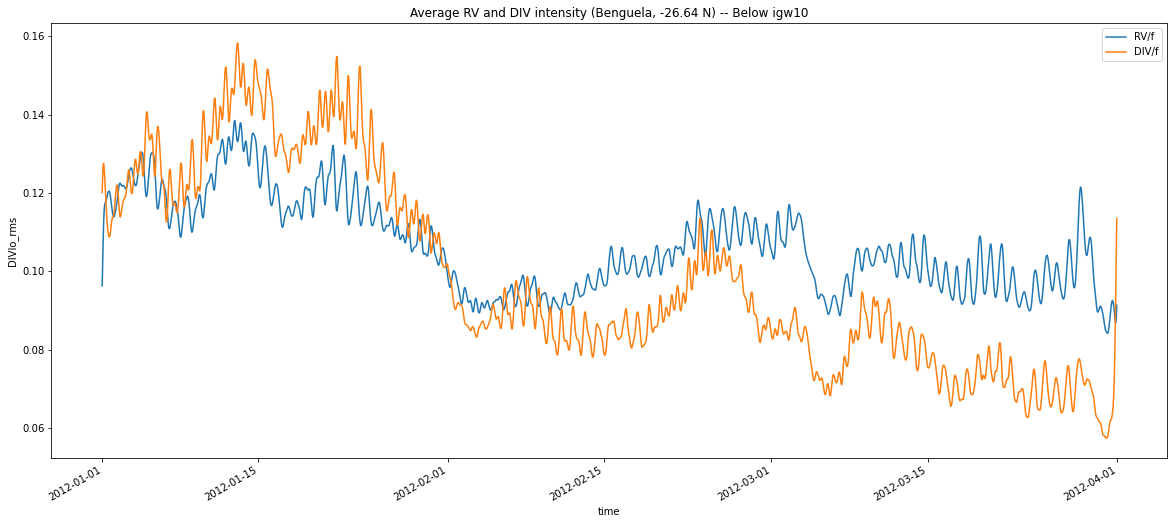

In [131]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.plot(label="RV/f", x="time")
ds.DIVlo_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current, lat_deg))
fig_std_bm_season = plt.gcf()
plt.show()

In [132]:
fig_std_bm_season.savefig('figs/{}/RV-DIV_{}_stdev_bm.png'.format(rid,season))

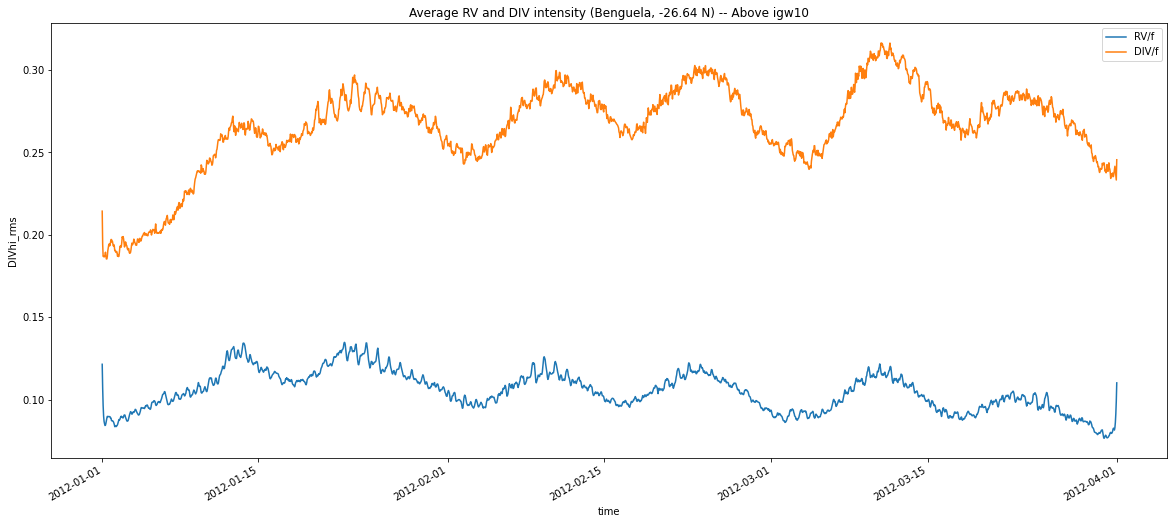

In [133]:
plt.figure(figsize=(20,8))
ds.RVhi_rms.plot(label="RV/f", x="time")
ds.DIVhi_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current, lat_deg))
fig_std_igw_season = plt.gcf()
plt.show()

In [134]:
fig_std_igw_season.savefig('figs/{}/RV-DIV_{}_stdev_igw.png'.format(rid,season))